In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os

/home/wald/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Read in all metrics into a dataframe (per class)

In [2]:

files = os.listdir("/user/christoph.wald/u15287/insect_pest_detection/metrics_collected")

rows = []

for file in files:
    f = os.path.join("/user/christoph.wald/u15287/insect_pest_detection/metrics_collected", file)
    with open(f, "r") as infile:
        data = json.load(infile)
        
        
        # Per-class rows
        for cls, stats in data["per_class"].items():
            row = stats.copy()
            row["file"] = file
            row["class"] = cls
            row["type"] = "per_class"
            rows.append(row)

# Convert to dataframe
df = pd.DataFrame(rows)
df["class"] = df["class"].astype(int)
print(df.head())


FileNotFoundError: [Errno 2] No such file or directory: '/user/christoph.wald/u15287/insect_pest_detection/metrics_collected'

In [4]:
# add per class F1-score
df["F1"] = 2 * (df["precision"] * df["recall"]) / (df["precision"] + df["recall"])


Find training/evaluation with maximum precision, recall and F1 per class

In [5]:
# Function to get row with max for a given column
def max_row_per_class(df, col):
    return df.loc[df.groupby("class")[col].idxmax(), ["class", "file", col]]

# Max precision per class
max_precision = max_row_per_class(df, "precision")
print("Max precision per class:")
print(max_precision)

# Max recall per class
max_recall = max_row_per_class(df, "recall")
print("\nMax recall per class:")
print(max_recall)

# Max F1 per class
max_f1 = max_row_per_class(df, "F1")
print("\nMax F1 per class:")
print(max_f1)

Max precision per class:
    class              file  precision
32      0  train6eval5.json   0.897644
45      1  train7eval5.json   0.943299
30      2  train6eval4.json   0.817450
23      3  train3eval4.json   0.947786

Max recall per class:
    class              file    recall
12      0  train2eval3.json  0.899937
17      1  train3eval3.json  0.938840
14      2  train2eval3.json  0.786927
15      3  train2eval3.json  0.887872

Max F1 per class:
    class              file        F1
36      0  train7eval3.json  0.876678
17      1  train3eval3.json  0.930709
2       2  train1eval1.json  0.747355
39      3  train7eval3.json  0.903478


Calculate total F1 values (without thrips)

In [6]:
classes_to_use = [0, 1, 3]
df_subset = df[df["class"].isin(classes_to_use)]

def micro_f1_per_file(group):
    TP_total = group["TP"].sum()
    FP_total = group["FP"].sum()
    FN_total = group["FN"].sum()
    
    precision_micro = TP_total / (TP_total + FP_total)
    recall_micro = TP_total / (TP_total + FN_total)
    micro_f1 = 2 * (precision_micro * recall_micro) / (precision_micro + recall_micro)
    return pd.Series({
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "micro_F1": micro_f1
    })

micro_metrics = df_subset.groupby("file", as_index=False).apply(micro_f1_per_file)
print(micro_metrics)


                file  precision_micro  recall_micro  micro_F1
0   train1eval1.json         0.907130      0.855128  0.880362
1   train1eval2.json         0.917565      0.872527  0.894480
2   train1eval3.json         0.922354      0.826740  0.871934
3   train2eval3.json         0.898760      0.902381  0.900567
4   train3eval3.json         0.903053      0.893956  0.898481
5   train3eval4.json         0.922236      0.834066  0.875938
6   train6eval3.json         0.918244      0.835165  0.874736
7   train6eval4.json         0.927878      0.822344  0.871929
8   train6eval5.json         0.930130      0.772894  0.844253
9   train7eval3.json         0.907590      0.895788  0.901650
10  train7eval4.json         0.922496      0.850183  0.884865
11  train7eval5.json         0.928495      0.799084  0.858943


/mnt/lustre-emmy-hdd/tmp/u15287/ipykernel_995984/1330414860.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  micro_metrics = df_subset.groupby("file", as_index=False).apply(micro_f1_per_file)


In [7]:
micro_metrics.sort_values("micro_F1", ascending = False)

,file,precision_micro,recall_micro,micro_F1
9,train7eval3.json,0.907590,0.895788,0.901650
3,train2eval3.json,0.898760,0.902381,0.900567
4,train3eval3.json,0.903053,0.893956,0.898481
1,train1eval2.json,0.917565,0.872527,0.894480
10,train7eval4.json,0.922496,0.850183,0.884865
0,train1eval1.json,0.907130,0.855128,0.880362
5,train3eval4.json,0.922236,0.834066,0.875938
6,train6eval3.json,0.918244,0.835165,0.874736
2,train1eval3.json,0.922354,0.826740,0.871934
7,train6eval4.json,0.927878,0.822344,0.871929


plot precision and recall per class and training/evaluation

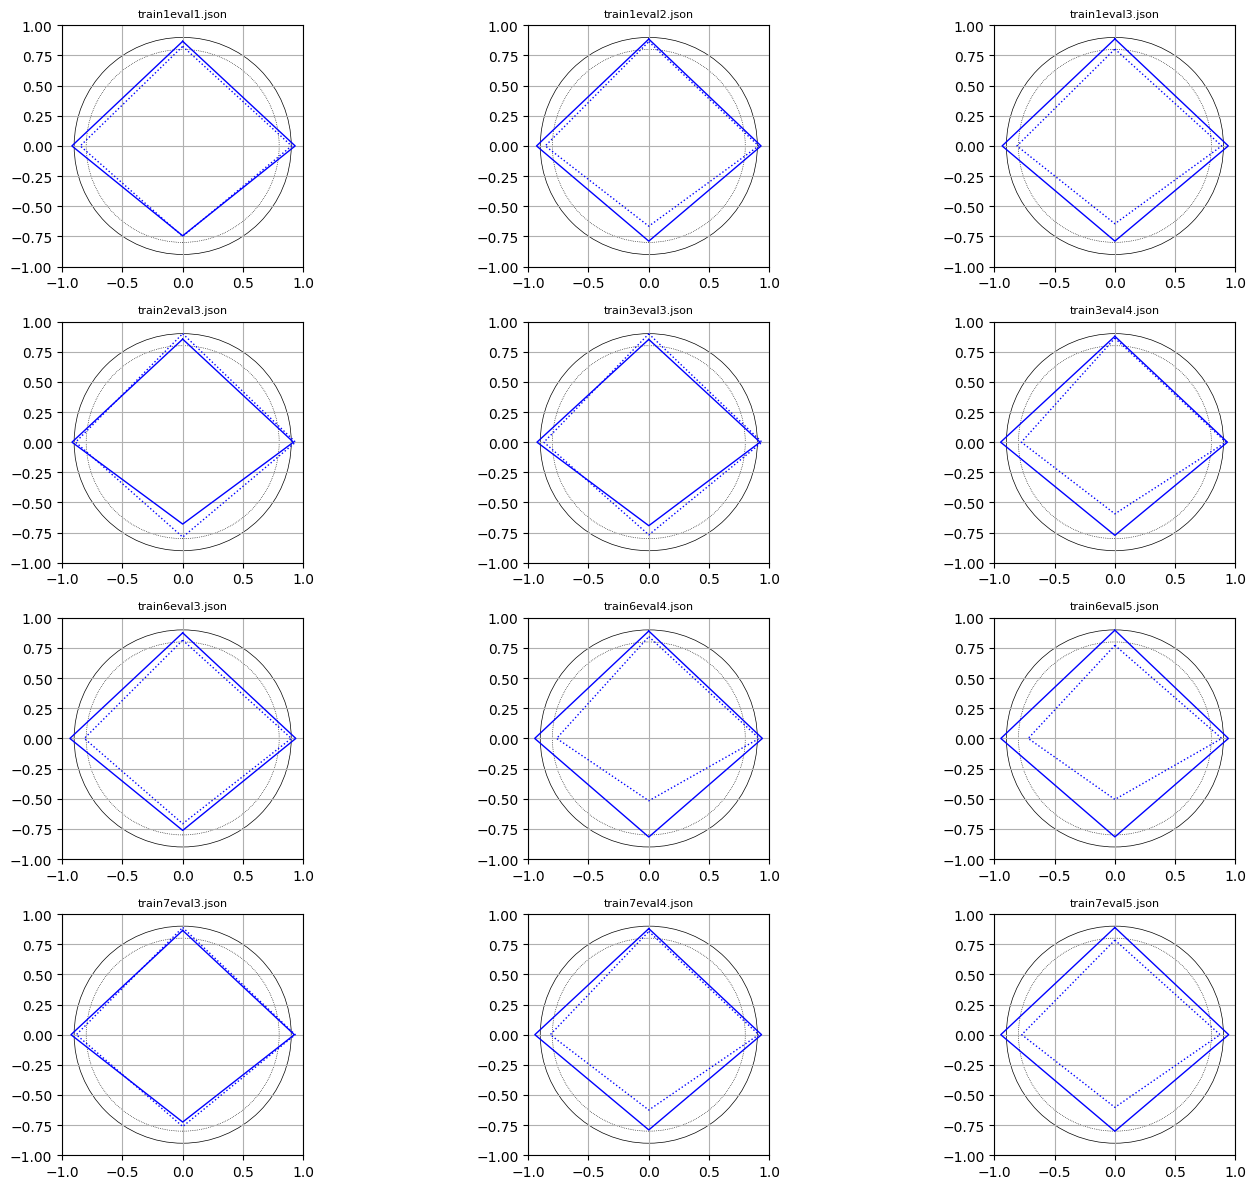

In [8]:
import matplotlib.pyplot as plt

def plot_precision_recall_on_ax(df, file_name, ax):
    """
    Plots precision and recall for the four classes of a given file on a given axis.
    """
    # Create reference circles
    circle1 = plt.Circle((0, 0), 0.8, color='black', linestyle='dotted', fill=False, linewidth=0.5)
    circle2 = plt.Circle((0, 0), 0.9, color='black', linestyle='solid', fill=False, linewidth=0.5)
    ax.add_patch(circle1)
    ax.add_patch(circle2)

    # Filter group
    group = df[df["file"] == file_name]

    # Extract precision and recall per class
    prec = [group[group["class"] == i]["precision"].values[0] for i in range(4)]
    rec  = [group[group["class"] == i]["recall"].values[0]    for i in range(4)]

    # Define points for precision and recall
    x_prec = [0, prec[1], 0, -prec[3], 0]
    y_prec = [prec[0], 0, -prec[2], 0, prec[0]]

    x_rec = [0, rec[1], 0, -rec[3], 0]
    y_rec = [rec[0], 0, -rec[2], 0, rec[0]]

    # Plot precision (solid)
    ax.plot(x_prec, y_prec, color='blue', linewidth=1, label='Precision')

    # Plot recall (dotted)
    ax.plot(x_rec, y_rec, color='blue', linewidth=1, linestyle='dotted', label='Recall')

    # Axis settings
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    ax.set_title(file_name, fontsize=8)

# --- Create 4x3 grid ---
files = df["file"].unique()
n_rows = 4
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, f in enumerate(files):
    plot_precision_recall_on_ax(df, f, axes[i])

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


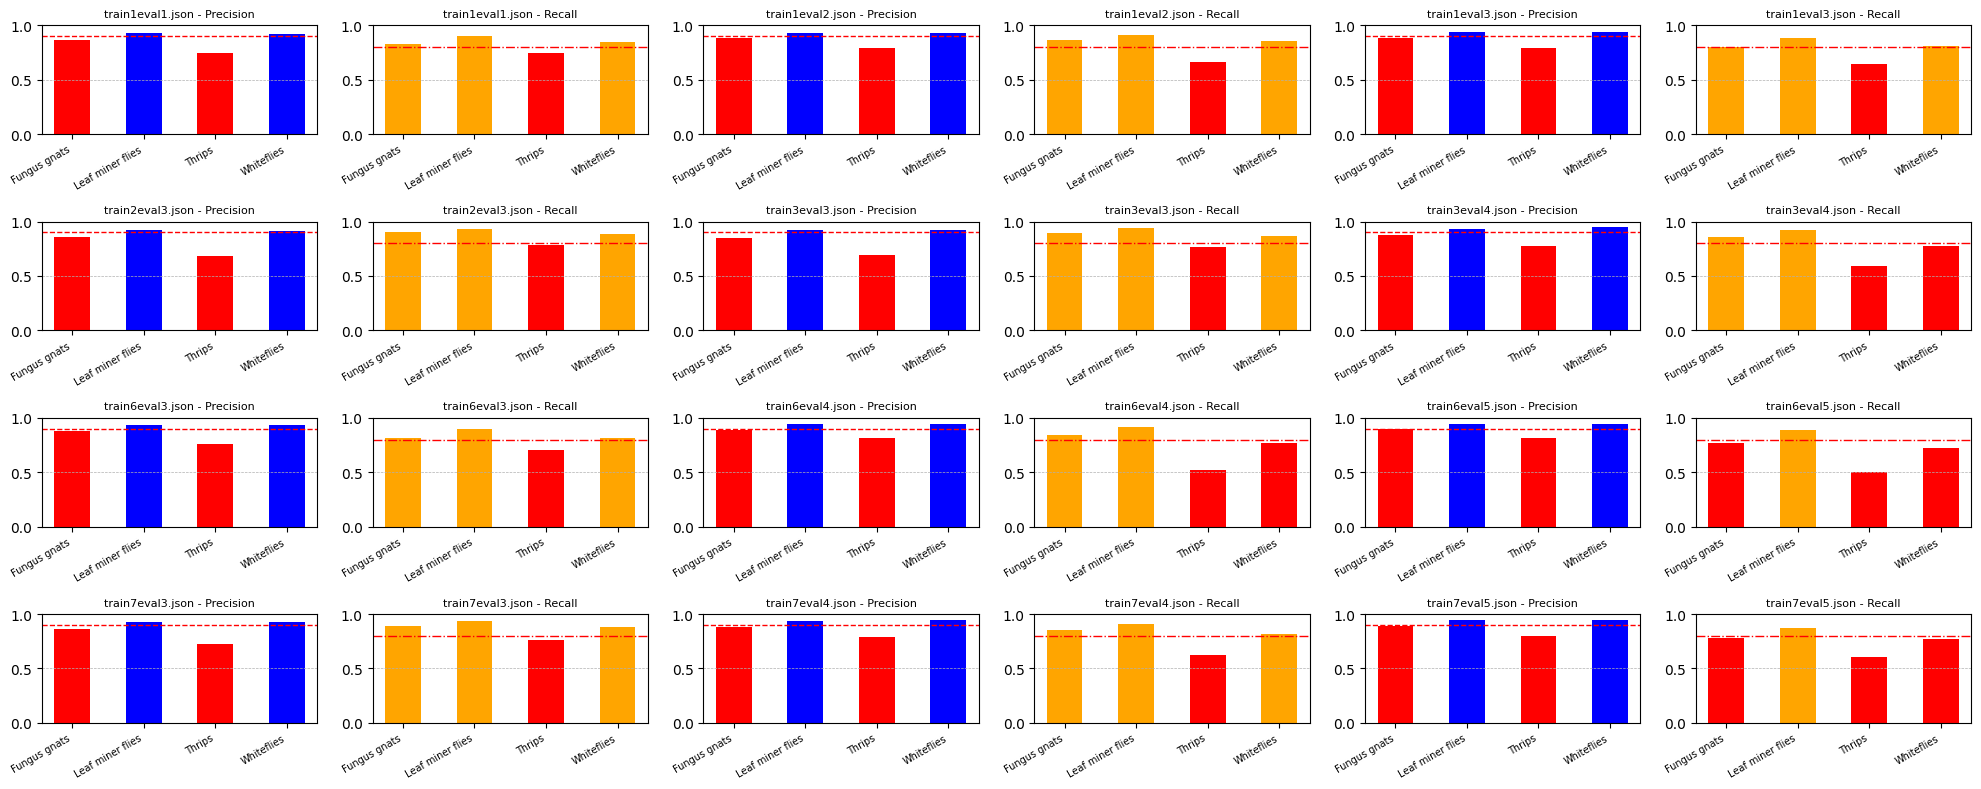

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metric_bar_on_ax(df, file_name, ax, metric="precision", base_color="blue", target=None, target_style="--"):
    """
    Plots bar plots for either precision or recall 
    for the four classes of a given file on a given axis.
    Bars below the threshold line are colored red.
    """
    # Filter group
    group = df[df["file"] == file_name]

    # Extract metric values
    classes = np.arange(4)
    values = [group[group["class"] == i][metric].values[0] for i in classes]

    # Assign colors: red if below target, otherwise base_color
    colors = []
    for v in values:
        if target is not None and v < target:
            colors.append("red")
        else:
            colors.append(base_color)

    # Plot bars
    ax.bar(classes, values, width=0.5, color=colors, label=metric.capitalize())

    # Add target line if specified
    if target is not None:
        ax.axhline(target, color='red', linestyle=target_style, linewidth=1, label=f"{metric.capitalize()} target ({target})")

    # Axis settings
    class_names = ["Fungus gnats", "Leaf miner flies", "Thrips", "Whiteflies"]
    ax.set_xticks(classes)
    ax.set_xticklabels([f'{class_names[i]}' for i in classes], rotation=30, ha="right", fontsize=7)
    ax.set_ylim(0, 1)
    ax.set_title(f"{file_name} - {metric.capitalize()}", fontsize=8)
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5)


# --- Create 2 rows, 6 columns grid ---
files = df["file"].unique()
n_files = len(files)

n_cols = 6   # 6 plots per row
n_rows = int(np.ceil(n_files * 2 / n_cols))  # 2 plots per file

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))
axes = axes.flatten()

for i, f in enumerate(files):
    # Precision plot
    plot_metric_bar_on_ax(df, f, axes[2*i], metric="precision", base_color="blue", target=0.9, target_style="--")
    # Recall plot
    plot_metric_bar_on_ax(df, f, axes[2*i+1], metric="recall", base_color="orange", target=0.8, target_style="-.")
    
# Hide unused subplots
for j in range(2*len(files), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



In [22]:
df

,TP,FP,FN,precision,recall,file,class,type,F1
0,1304,199,275,0.867598,0.825839,train1eval1.json,0,per_class,0.846204
1,1137,82,122,0.932732,0.903098,train1eval1.json,1,per_class,0.917676
2,883,302,295,0.745148,0.749576,train1eval1.json,2,per_class,0.747355
3,2228,197,394,0.918763,0.849733,train1eval1.json,3,per_class,0.882901
4,1366,176,213,0.885863,0.865104,train1eval2.json,0,per_class,0.875360
5,1147,85,112,0.931006,0.911041,train1eval2.json,1,per_class,0.920915
6,784,209,394,0.789527,0.665535,train1eval2.json,2,per_class,0.722248
7,2251,167,371,0.930935,0.858505,train1eval2.json,3,per_class,0.893254
8,1269,161,310,0.887413,0.803673,train1eval3.json,0,per_class,0.843470
9,1115,71,144,0.940135,0.885624,train1eval3.json,1,per_class,0.912065
